## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists to determine performance of website. An e-commerce website has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Read data from csv file and Load it into dataframe and print first n rows 
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
print('Number of rows: {}'.format(df.shape[0]))

Number of rows: 294478


c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[(df['landing_page'] == 'new_page') == (df['group'] != 'treatment')].shape[0]

3893

**Note:** 3893 rows are doesn't line up correctly. So, we need to remove those rows to optimize.

f. Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**Note:** Dataset doesn't have any null values

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Remove the rows which landing page and group are doesn't lined up correctly and Store new dataframe in **df2**.

In [8]:
# Find row index where treatment is not aligned with new_page and control is not aligned with old_page
drop_index = df[((df['landing_page'] != 'new_page') == (df['group'] == 'treatment')) | ((df['landing_page'] != 'old_page') == (df['group'] == 'control'))].index

# Drop found index rows and store it as df2
df2 = df.drop(drop_index)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
print('Number of rows in new dataframe: {}'.format(df2.shape[0]))

Number of rows in new dataframe: 290585


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** below to find answer for below questions

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

- **Note:** User id has one duplicate value

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
dup_user = df2[df2.duplicated(['user_id'])].user_id.iloc[0]
dup_user

773192

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'], keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
# Remove the first duplicated row and Keep the last row as last row has the latest timestamp  
df2.drop(df2[df2.duplicated(['user_id'], keep = 'last')].index,inplace = True)

# Check whether duplicate rows is dropped - it should return 0
df2.user_id.duplicated().sum()

0

In [15]:
# Check for the user id information
df2[df2['user_id'] == dup_user]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** to find statistics of new dataframe

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page == "new_page"')['converted'].count()/df2.shape[0]

0.5000619442226688

e. **Descriptive statistics observation:**

- Probability of user receiving new page is about 50%. So, old page might also have the same probability.
- Converted mean of treatment group is 11.88% and control group is 12.03%. The difference between converted means of control and treatment group extremely small.
- So, there is no sufficient evidence to say that treatment page leads to more conversions since new page doesn't lead to more conversions on average compare with the old page and converted mean of treatment group is slightly less than actual converted mean regardless of page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  

- Null hypothesis($H_0$) and Alternative hypothesis(($H_1$) in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**Note:** Since, under the null hypothesis,  $p_{new}$  and  $p_{old}$  both have "true" success rates equal to the converted success rate regardless of page, **convert rate** for $p_{old}$ and $p_{new}$ are same.

c. What is $n_{new}$?

In [22]:
# number of individuals in the treatment group                             
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [23]:
# number of individuals in the control group
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0,1], size = n_new, p = [(1-p_new), p_new])
new_page_converted.mean()

0.12038400660656527

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0,1], size = n_old, p = [(1-p_old), p_old])
old_page_converted.mean()

0.11991133995071382

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.00047266665585145307

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.

In [28]:
# Compute the converated rate of each group
treatment_mean = df2.query('group == "treatment"')['converted'].mean()
control_mean = df2.query('group == "control"')['converted'].mean()

# Find the Actual observed difference
obs_diffs = treatment_mean - control_mean
obs_diffs

-0.0015782389853555567

In [29]:
# Convert p_diffs into numpy array
p_diffs = np.array(p_diffs)

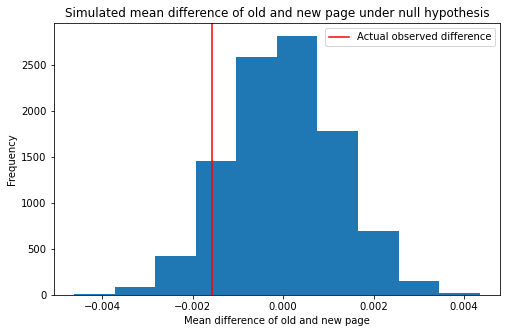

In [30]:
# Set figure size
plt.figure(figsize = (8,5))

# Plot a histogram of the p_diffs
plt.hist(p_diffs)

# Mark the converted mean difference 
plt.axvline(x = obs_diffs, color = 'red', label = 'Actual observed difference');

# Set plot properties
plt.title('Simulated mean difference of old and new page under null hypothesis')
plt.xlabel('Mean difference of old and new page')
plt.ylabel('Frequency')
plt.legend();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
(p_diffs > obs_diffs).mean()

0.9042

k. **Plot Observation Results:**

- The computed value in **j** is called as **P-value** in scientific studies which is actual observerd difference versus the Simulated mean difference of old and new page under null hypothesis.
- **P-value** = **0.9** which is greater than the typical Type I error rate of 5% ($\alpha$ = 0.05). So, we **Fail to reject the null**
- There is **no sufficient evidence to the new page converts more users than the old page**

l. We could also use a built-in to achieve similar results using **statsmodels**.  

In [32]:
import statsmodels.api as sm

# number of conversions for each page
convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]

#number of rows associated with the old page and new pages
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
zstat, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
zstat, pval

(-1.3109241984234394, 0.9050583127590245)

In [34]:
# 95% confidence interval using scipy norm
from scipy.stats import norm
norm.ppf(1-(0.05))

1.6448536269514722

n. **ztest Observation Results:**

- ztest allow us to compare the proptions and help us to decide whether null hypothesis should be rejected or not
- **zstat/zscore** is **-1.31** which is less than the 95% confidence interval which means zscore is 1.31 standard deviation below the mean.
- **pval** is **0.9** which similar to the p-value observed in above hypothesis testing and it is greater than the Type I error rate of 5% ( 𝛼  = 0.05)
- So, we **Fail to reject the null**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, **Logistic regression** can be performed as we have only two outcomes to predict

b. Here, logistic regression is used to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
#create a column for the intercept
df2['intercept'] = 1

# create dummy variable columns for landing_page
# especially for **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control** 
df2[['ab_page', 'old_page']] = pd.get_dummies(df2.landing_page)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import regression model.  Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [36]:
# Instantiate the model
log_mod = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])

# Fit the model
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Summary of model:

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:               8.077e-06
Time:                        22:30:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. **Logistic regression results:**

- **p-value** is 0.190 which is higher than the common significant level($\alpha$ = 0.05). So, the treatment new page is **not staistically significant** with conversion rates.
- p-value found in logistic regression is differs from the p-value found in Part II.
    - Part II Hypothesis test - **one sided test** which is used to decide new page converts more users than the old page or not 
    $$H_0: p_{new} - p_{old} \leq 0$$
    $$H_1: p_{new} - p_{old} > 0$$
    - Part III Logistic Regression - **two sided test** which is used to  find the relationship between coversion and landingpage
    $$H_0: p_{new} - p_{old} = 0$$
    $$H_1: p_{new} - p_{old} \ne 0$$

f. **Considering other factor in regression model:** 

- Since the landing page is not staistically significant with conversion, we need to consider other facors as the conversion is biased with different characteristics of different users. So, we need to add other factorts into our regression model rather than group and landing_page
- Disadvantages: considering multiple factors into regression model will lead to multicollinearity, outliers and non linear relationship

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We need to read in the **countries.csv** dataset and merge together our existing datasets on the approporiate rows to find the relationship between country and the conversion rates of the two pages. 

In [38]:
# Read data from csv file
countries_df = pd.read_csv('./countries.csv')

# Crete new dataframe by joing country dataframe and existing dataframe
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [39]:
# Find uniques values in country to create dummy variables
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new.country)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [41]:
# Instantiate the model for conversion and countries
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])

# Fit the new model
results = log_mod.fit()

# Summary results of model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:               2.323e-05
Time:                        22:31:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**Observation:**
- **p-value** of the countries are higher than the significance level($\alpha$ = 0.05). So, the countries factor alone is **not staistically significant** with conversion rates. So, Lets find out the interaction between country and the conversion rates of the two pages.

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [42]:
#create interaction between page and country
df_new['uk_page'] = df_new.ab_page * df_new.UK
df_new['us_page'] = df_new.ab_page * df_new.US
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,US,uk_page,us_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1,0


In [43]:
# Instantiate the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'uk_page', 'us_page']])

# Fit the model
results = log_mod.fit()

# Summary results of model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:               3.482e-05
Time:                        22:31:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
uk_page        0.0783      0.057      1.378      0.168      -0.033       0.190
us_page        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

**Regression Results:**
- P-value of country factors are higher the the significace level($\alpha$ = 0.05). So, there is **no sufficient evidence** to say that **interaction between page and country doesn't have significant effects on conversion**

### Relationship between timestamp and the conversion rates

**To find the association between day of weeks and conversion, create dummy variables to instantiate and fit the model**

In [44]:
# Check maximum and minimum timestamp
df_new.timestamp.min(), df_new.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

- **Note:** As per the maximum and minimum timestamp, we could see that it consists of limited timestamp duration (22 days in January)

In [45]:
# convert the datatype for  timestamp columns
df_new.timestamp = pd.to_datetime(df_new.timestamp)

# Find uniques values of dayofweeks in timestamp to create dummy variables
df_new.timestamp.dt.dayofweek.value_counts()

1    47148
0    45439
6    39915
5    39670
4    39626
2    39565
3    39221
Name: timestamp, dtype: int64

- **Note:** Pandas Timestamp.dayofweek attribute return the value of day of the week in the given Timestamp object. The days are numbered from 0 to 6 where 0 is Monday and 6 is Sunday

In [46]:
# Create dummy variable for day of the week
df_new[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] = pd.get_dummies(df_new.timestamp.dt.dayofweek)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,US,uk_page,us_page,Mon,Tue,Wed,Thu,Fri,Sat,Sun
user_id,,,,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0


**Regression based on weekday and conversion**

In [47]:
# Instantiate the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri']])

# Fit the model
results = log_mod.fit()

# Summary results of model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            6
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:               2.915e-05
Time:                        22:32:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.4010
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9884      0.012   -161.577      0.000      -2.012      -1.964
ab_page       -0.0149      0.011     -1.306      0.191      -0.037       0.007
Mon            0.0142      0.018      0.787      0.431      -0.021       0.050
Tue           -0.0010      0.018     -0.056      0.955      -0.036       0.034
Wed            0.0065      0.019      0.346      0.729      -0.031       0.044
Thu            0.0030      0.019      0.160      0.873      -0.034       0.040
Fri           -0.0283      0.019     -1.483      0.138      -0.066       0.009
==============================================================================
"""

**Results:**
- **p-value** of weekdays are higher than the significance level($\alpha$ = 0.05). So, the weekdays alone **not staistically significant** with conversion rates. So, Lets find out the interaction between weekdays and the conversion rates of the two pages.

In [48]:
# create interaction between page and weekdays
df_new['mon_page'] = df_new.ab_page * df_new.Mon
df_new['tue_page'] = df_new.ab_page * df_new.Tue
df_new['wed_page'] = df_new.ab_page * df_new.Wed
df_new['thu_page'] = df_new.ab_page * df_new.Thu
df_new['fri_page'] = df_new.ab_page * df_new.Fri
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,...,Wed,Thu,Fri,Sat,Sun,mon_page,tue_page,wed_page,thu_page,fri_page
user_id,,,,,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [49]:
# Instantiate the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'mon_page', 'tue_page', 'wed_page', 'thu_page', 'fri_page']])

# Fit the model
results = log_mod.fit()

# Summary results of model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366094
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290572
Method:                           MLE   Df Model:                           11
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:               7.411e-05
Time:                        22:32:47   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1499
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9733      0.015   -129.017      0.000      -2.003      -1.943
ab_page       -0.0455      0.022     -2.083      0.037      -0.088      -0.003
Mon            0.0071      0.025      0.279      0.780      -0.043       0.057
Tue           -0.0503      0.025     -1.981      0.048      -0.100      -0.001
Wed           -0.0019      0.027     -0.071      0.944      -0.054       0.050
Thu           -0.0029      0.027     -0.108      0.914      -0.055       0.049
Fri           -0.0592      0.027     -2.191      0.028      -0.112      -0.006
mon_page       0.0145      0.036      0.402      0.687      -0.056       0.085
tue_page       0.0986      0.036      2.753      0.006       0.028       0.169
wed_page       0.0172      0.038      0.454      0.650      -0.057       0.091
thu_page       0.0122      0.038      0.320      0.749      -0.062       0.087
fri_page       0.0621      0.038      1.626      0.104      -0.013       0.137
==============================================================================
"""

**Regression Results:**
- From the results summary, we could see that only **Tuesday, Friday** and **interaction of Tuesday and landing page** are having **p-value** less than the significance level($\alpha$ = 0.05)

**Regression based on weekend and conversion**

In [50]:
# Instantiate the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'Sat', 'Sun']])

# Fit the model
results = log_mod.fit()

# Summary results of model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:               1.296e-05
Time:                        22:33:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.4304
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9889      0.009   -226.066      0.000      -2.006      -1.972
ab_page       -0.0150      0.011     -1.310      0.190      -0.037       0.007
Sat            0.0117      0.017      0.698      0.485      -0.021       0.045
Sun           -0.0105      0.017     -0.624      0.533      -0.044       0.023
==============================================================================
"""

**Results:**
- **p-value** of weekends are higher than the significance level($\alpha$ = 0.05). So, the **weekends** alone **not staistically significant** with conversion rates. So, Lets find out the interaction between weekends and the conversion rates of the two pages.

In [51]:
# create interaction between page and weekdays
df_new['sat_page'] = df_new.ab_page * df_new.Sat
df_new['sun_page'] = df_new.ab_page * df_new.Sun
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,...,Fri,Sat,Sun,mon_page,tue_page,wed_page,thu_page,fri_page,sat_page,sun_page
user_id,,,,,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [52]:
# Instantiate the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'Sat', 'Sun', 'sat_page', 'sun_page']])

# Fit the model
results = log_mod.fit()

# Summary results of model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:               3.195e-05
Time:                        22:33:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2362
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9947      0.009   -210.235      0.000      -2.013      -1.976
ab_page       -0.0035      0.013     -0.259      0.796      -0.030       0.023
Sat            0.0448      0.023      1.909      0.056      -0.001       0.091
Sun           -0.0023      0.024     -0.097      0.922      -0.049       0.044
sat_page      -0.0673      0.034     -2.002      0.045      -0.133      -0.001
sun_page      -0.0165      0.034     -0.489      0.625      -0.083       0.050
==============================================================================
"""

**Regression Results:**
- From the results summary, we could see that only the **interaction of Saturday and landing page** is having **p-value** less than the significance level($\alpha$ = 0.05)

**To find the association between time and conversion, create dummy variables to instantiate and fit the model**

create a dummy variable column for **AM** and **PM** based on timestamp hour where **hour < 12** is **AM** and **hour > 12** is **PM**

In [53]:
df_new['AM'] = np.where((df_new.timestamp.dt.hour < 12), 1, 0)
df_new['PM'] = np.where((df_new.timestamp.dt.hour > 12), 1, 0)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,...,Sun,mon_page,tue_page,wed_page,thu_page,fri_page,sat_page,sun_page,AM,PM
user_id,,,,,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,...,1,0,0,0,0,0,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1


**Regression based on AM and conversion**

In [54]:
# Instantiate the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'AM']])

# Fit the model
results = log_mod.fit()

# Summery results of model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:               2.798e-05
Time:                        22:33:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.05097
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9771      0.010   -200.589      0.000      -1.996      -1.958
ab_page       -0.0150      0.011     -1.314      0.189      -0.037       0.007
AM            -0.0235      0.011     -2.058      0.040      -0.046      -0.001
==============================================================================
"""

**Regression Results:**
- **AM** is having **p-value** less than the significance level($\alpha$ = 0.05)

In [55]:
# Instantiate the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'PM']])

# Fit the model
results = log_mod.fit()

# Summery results of model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 27 Jul 2021   Pseudo R-squ.:               1.813e-05
Time:                        22:33:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1454
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9965      0.010   -206.940      0.000      -2.015      -1.978
ab_page       -0.0150      0.011     -1.310      0.190      -0.037       0.007
PM             0.0168      0.011      1.463      0.144      -0.006       0.039
==============================================================================
"""

**Regression Results:**
- **PM** is having **p-value** higher than the significance level($\alpha$ = 0.05)

<a id='conclusions'></a>
## Conclusions

- **Probability:** The descriptive statistics have shown that the new and old page have an approximately equal chance of converting users and difference between converted means of control and treatment group extremely small.
- **A/B Test:** The actual observerd difference versus the Simulated mean difference of old and new page under null hypothesis has high p-value 0.9. So, we **Fail to reject the null** and there is **no sufficient evidence to the new page converts more users than the old page**
- **Z-Test:** using statsmodel we have got the same result which is similar to A/B testing - **no significant difference**
- **Logistic Regression:**
    - The old and new page doesn't have the significant linear relationship with conversion rates as 
    - Individual countries and interaction between landing page and country doesn't have significant effects on conversion
    - Based on the relationship between timestamp and the conversion rates, weekday, weekend and AM regressions are having modest significance with hardly any variable.
> Based on the comprehensive observation results, **we don't have significant evidence to suggest that the new page results in more conversions than the old page**. The e-commerce company should run the experiment longer to make their decision regarding old and new page coversions as the ab_data dataset consists of limited timestamp duration.

**References :**
<ul>
    <li><a>https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/</a></li>
    <li><a>https://stackoverflow.com/questions/60699836/how-to-use-norm-ppf</a></li>
    <li><a>https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html</a></li>
    <li><a>https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.hour.html</a></li>
    <li><a>https://github.com</a></li>
</ul>